In [1]:
%matplotlib inline
import numpy as np
from numpy import genfromtxt  
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

## Plotting functions

In [2]:
 def scatter(*data):
    '''
    scatter plot of 1dim data
    
    data list of 1 dim data
    '''
    
    plt.figure(figsize=(9,2))
    
    for x in data:
        plt.scatter(x, np.zeros((len(x), 1)))
        
    plt.yticks(())
    plt.show()
    
def plt_with_gaussians(data, mean, variance):
    '''
    scatter the data,
    and plot the given gaussian distributions
    
    data 1dim data to be scattered
    mean means of the normal distributions
    variance variances of the normal distributions
    '''
    
    plt.figure(figsize=(14, 7))
    
      # generate x values with min and max of the data
    x_values = np.linspace(data.min(), data.max(), 1001)
    # show the gaussians 
    for mu, sig in zip(mean, variance):
        plt.plot(x_values, gaussian(x_values, mu, sig))
        
    # scatter data points on x axis
    plt.scatter(data, np.zeros((len(data), 1)))
    
    plt.yticks(())
    plt.show()

## implementation of

- Gaussian distribution function
- Expectation Maximazation Algorithm
- Akaike Information Criterion

In [3]:
def gaussian(x, mu, sig):
    '''
    returns the likelihood of a point in a one dimensional gaussian
    
    x x value(s)
    mu mean of the gaussian
    sig variance of the gaussian 
    '''
    return (1 / np.sqrt(2 * np.pi * sig)) * np.exp(-((x - mu) ** 2) / (2 * sig))

In [4]:
def kmeans(data, k, n=10):
    '''
    kmeans clustering algorithm
    
    data 1d array data
    k number of clusters / means
    n times to repeat algorithm
    
    returns means
    '''
    
    # ensure data are 1d ndarray
    data = np.array(data).flatten()
    
    # init means randomly
    mu = np.random.uniform(low=data.min(), high=data.max(), size=k)
     
    # loop through algorithm n times 
    for i in range(n):
        # augment data array k times, then calculate distances to means
        dist = np.abs(data * np.ones(k).reshape(-1, 1) - mu.reshape(-1, 1))
        # generate indices of which point belongs to which cluster
        cluster_indices = dist.swapaxes(0, 1).argmin(axis=1)
        # recalculate means
        for j in range(k): 
            mu[j] = data[cluster_indices == j].mean()
             
    
    return mu 

In [5]:
def em(data, k=1, n=1, init='kmeans', plot=False):
    '''
    1d expectation maximazation algorithm
    
    data 1d numpy array of data
    k number of normal distributions
    n number of em repetitions
    init [default='random', 'kmeans'] how to initialize means and variances
    plot If true, will plot every step
    
    returns mixing coefficients, means, variances
    '''
    
    # ensure data are 1d ndarray
    data = np.array(data).flatten()
    
    # list of means and variances of the k normal distributions to be fitted
    # init randomly between min and max points of data
    min_data, max_data = data.min(), data.max() 
    
    prior = np.full(k, 1 / k)  # assume priors (mixing coefficents) are equal
    variance = np.random.uniform(low=np.absolute(min_data / 2), high=np.absolute(max_data/2), size=k)
     
    if init == 'random':
        mean = np.random.uniform(low=min_data, high=max_data, size=k)
    elif init == 'kmeans':
        # use kmeans implementation for mean initialization
        mean = kmeans(data, k, 20)
        print(mean)
     
    # repeat algorithm n times
    for i in range(n):
        
        p_x_b = []
        
        # loop through each distribution j
        for j in range(k):
            # calcualate for each point the generative probability that it belongs to the distribution j
            # P(x | b)
            p_x_b.append(gaussian(data, mean[j], variance[j]))
            
        # convert to numpy array
        p_x_b = np.array(p_x_b)
         
        # calculate for each point the probability that it belongs to a distribution,
        # summing up to one ('colorings of the points')
        # P(b|x)
        p_wp = p_x_b * prior.reshape(-1, 1)
        bi =  p_wp / p_wp.sum(axis=0)
         
        # reestimate means
        mean = (bi * data).sum(axis=1) / bi.sum(axis=1)
        
        # reestimate variances
        for j in range(k):
            variance[j] = (bi[j] * (data - mean[j])**2).sum() / bi[j].sum()
            
        # reestimate priors
        unique, counts = np.unique(bi.swapaxes(0, 1).argmax(axis=1), return_counts=True)
        # counts array are in the correct order the counts of points that have the max likelihood
        # if no point belongs to one of the distributions replace this index with a zero in counts
        # compare with np.arange
        unique, counts = unique.tolist(), counts.tolist()
        for m in range(k):
            if m == len(unique) or unique[m] != m:
                unique.insert(m, -1)
                # insert small epsilon so that prior is not zero (division by zero)
                counts.insert(m, 1e-6)
                
                  
        prior = np.array(counts) / data.shape[0]
        
        # plot if shall plot
        if plot:
            plt_with_gaussians(data, mean, variance)
         
        
    # return means and variances
    return prior, mean, variance 

In [6]:
def aic(data, mixing_coefficent, mean, variance):
    '''
    return best model to the Akaike Information Criterion
    
    data 1dim data
    mixing_coefficents mixing coefficients / priors pi
    mean means of the gaussians mu 
    variance variances of the gaussians sigma
    '''
    
    # ensure data are flat ndarray
    data = np.array(data).flatten()
    
    # calculate K (number of parameters)
    K = len(mean) * 3 - 1  # len of prior, mean and variance should be the same
    
    # calculate log-likelihoods
    LL = 0 
        
    for pi, mu, sig in zip(mixing_coefficent, mean, variance):
        LL += pi * gaussian(data, mu, sig)
         
    LL = np.log(LL).sum()
         
    return -2 * LL + 2 * K

### load datasets

In [7]:
def load_iris():
    '''
    Returns a column of all petal lengths.
    '''
    X = genfromtxt("./data/iris.csv", delimiter=',', skip_header=1)
    X = X[:,2]
    X = X.reshape(-1, 1)
    return X

def load_bdp():
    '''
    Returns a column of systolic and diastolic blood pressure values.
    '''
    Z = genfromtxt("./data/bdp.csv", delimiter=',', skip_header=1)
    n = Z.shape[0]
    X = np.zeros(2*n)
    X[:n] = Z[:,2]
    X[n:] = Z[:,3]
    X = X.reshape(-1,1)
    return X

def sample(pi, mu, std, n):
    '''
    Returns a column of n values drawn from a normal mixture model.
    
    Parameter
        pi  k mixing coefficients
        mu  k means
        std k standard deviations
        n   number of data points
        
    Return
        n data points randomly sampled from specified mixture. 
    '''
    y = np.random.choice(len(pi), size=n, p=pi)
    x = np.zeros((n,1))
    for i, comp in enumerate(y):
        x[i] = norm.rvs(mu[comp], std[comp])
    return x


## Examples

[100.04859608 149.89906806 200.17063127]


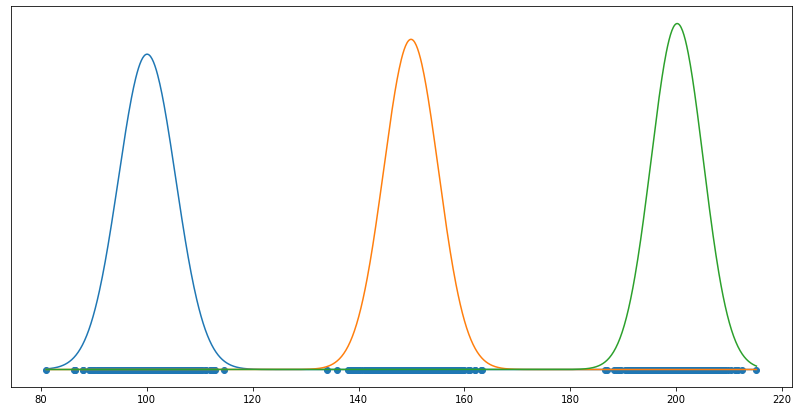

In [8]:
# generate n points from a mixture of fived normal distributions
n = 1000
mu = [100, 150, 200]
std = 5 * np.ones(len(mu))
pi = np.ones(len(mu))/ len(mu)
sample_x = sample(pi, mu, std, n)

priors, mu, sig = em(sample_x, 3, 10)
plt_with_gaussians(sample_x, mu, sig)

[1.49411765 4.92525253]


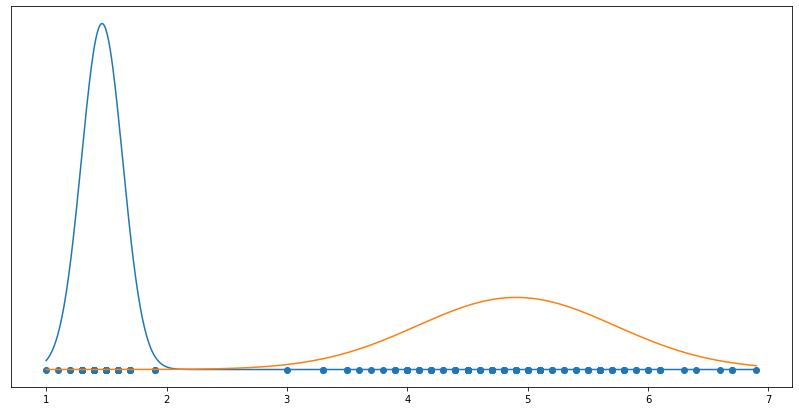

In [9]:
# load petal lengths of iris flowers
iris_x = load_iris()
priors, mu, sig = em(iris_x, 2, 10)
plt_with_gaussians(iris_x, mu, sig)

[ 76.50993377 124.39735099]


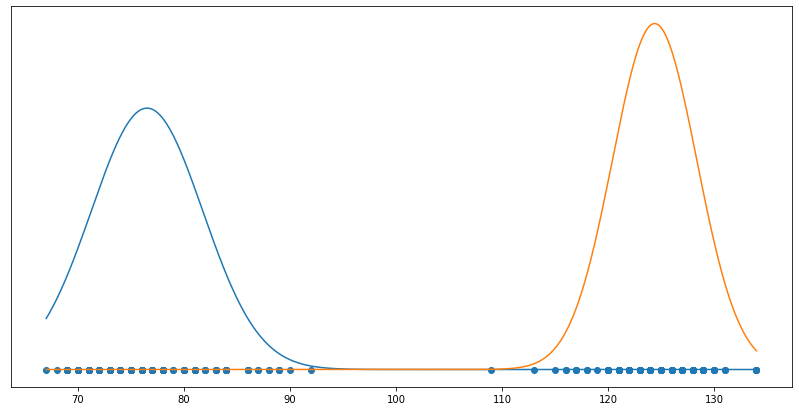

In [10]:
# load blood pressures
bdp_x = load_bdp()
priors, mu, sig = em(bdp_x, 2, 10)
plt_with_gaussians(bdp_x, mu, sig)

### compare my algorithm with sklearn's GMM

In [11]:
for j in range(1, 6):
    # sklearns EM / GMM
    gmm = GaussianMixture(n_components=j, init_params='kmeans', max_iter=100, reg_covar=1e-2)
    gmm.fit(sample_x)
     
    # my gmm 
    my_pi, my_mu, my_sig = em(sample_x, j, 10)
    sk_mu, sk_sig = sk_pi = gmm.means_.flatten(), gmm.covariances_.flatten()
    
    # print difference
    print(f'\n{j}')
    print(f'my mus = {my_mu}')
    print(f'sk mus = {sk_mu}')
    print(f'my sig = {my_sig}')
    print(f'sk sig = {sk_sig}')
    print(f'my aic = {aic(sample_x, my_pi, my_mu, my_sig)}')
    print(f'sk aic = {gmm.aic(sample_x)}')

[148.18261233]

1
my mus = [148.18261233]
sk mus = [148.18261233]
my sig = [1639.53128556]
sk sig = [1639.54128556]
my aic = 10244.042744888899
sk aic = 10244.0427449075
[199.92947645 125.36627167]

2
my mus = [200.33221411 126.26361926]
sk mus = [172.08293491  99.90812284]
my sig = [ 22.60087371 695.63410228]
sk sig = [712.76940153  27.25689279]
my aic = 9537.284876759193
sk aic = 9535.431757423514
[200.17063127 149.89906806 100.04859608]

3
my mus = [200.17063127 149.89906807 100.04859611]
sk mus = [100.04859611 149.89906807 200.17063127]
my sig = [24.26206589 26.63655129 29.20587387]
sk sig = [29.21587387 26.64655129 24.27206589]
my aic = 8332.188239646523
sk aic = 8332.188310438683
[100.04859608 153.67860424 145.3962873  200.17063127]

4
my mus = [100.04859611 149.89906809 145.88384246 200.17063127]
sk mus = [200.17063127 103.51292743 149.89906806  96.50802395]
my sig = [29.20587387 26.63655125 27.45355394 24.26206589]
sk sig = [24.27206589 16.03097298 26.64655148 17.88957168]
my a

# conduct experiment of the assignment

In [12]:
# conduct experiment
def select_gmm(data, log='v'):
    '''
    selects the best model according to aic for k = {1..15}
    
    data 1dim data array
    log [default='v(erbose)', 'vp (verbose-plot)', n(one)]
    '''
    
    # best model and aic
    best = None
    
    for k in range(1, 16):
        # generate gmm
        pi, mu, sig = em(data, k, n=10)  # let em loop n times
        
        # calc aic
        t_aic = aic(data, pi, mu, sig)
        
        # create model dict
        model = {
            'k': k,
            'pi': pi, 
            'mu': mu, 
            'sig': sig, 
            'aic': t_aic
        }
        
        # print model if is verbose
        if log == 'v' or log == 'vp': 
            print(k, t_aic)
        if log == 'vp':
            plt_with_gaussians(data, mu, sig)
        
        # compare current looping model to best model
        if best == None or t_aic > best['aic']:
            best = model
            
            if log == 'v' or log == 'vp':
                print('This is the new best model according to aic (above)!')
        
            
    return best
        
def sel_plt(data):
    '''
    select and plot best model according to aic
    
    data 1dim data array
    '''
    
    model = select_gmm(data, log='vp')
    print('best model:')
    plt_with_gaussians(data, model['mu'], model['sig'])

[148.18261233]
1 10244.042744888899


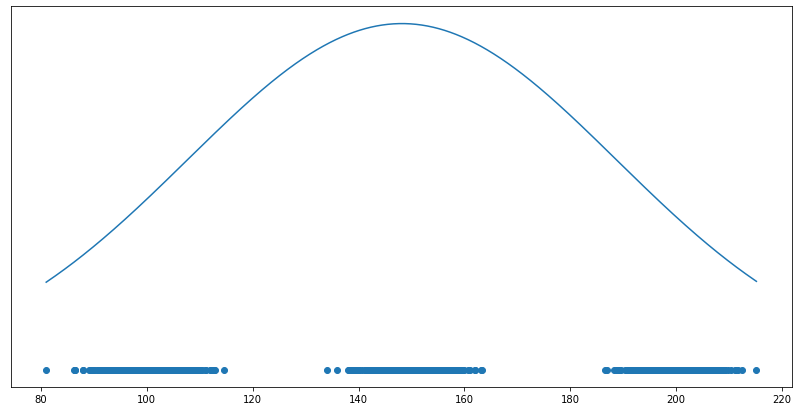

This is the new best model according to aic (above)!
[125.36627167 199.92947645]
2 9537.284876752297


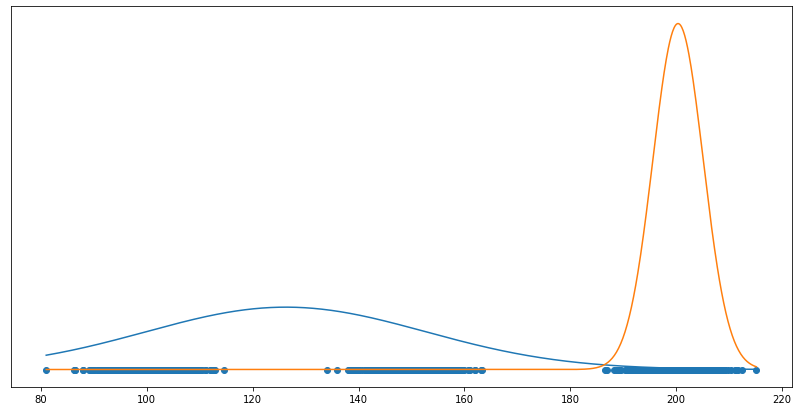

[100.04859608 200.17063127 149.89906806]
3 8332.188239646523


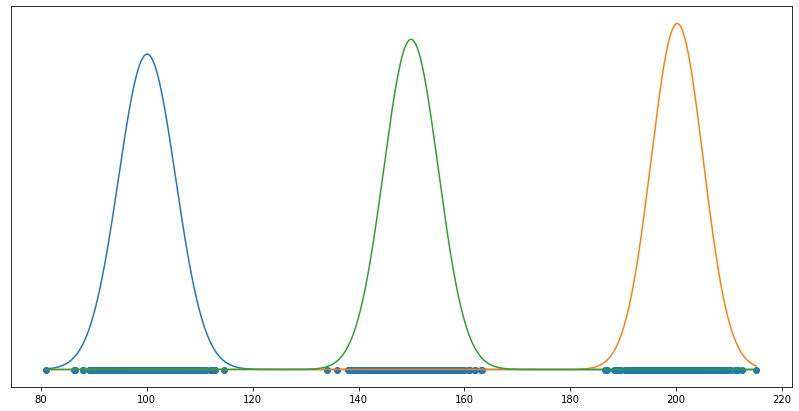

[200.17063127 104.58498005 149.89906806  95.89449166]
4 8338.188237635339


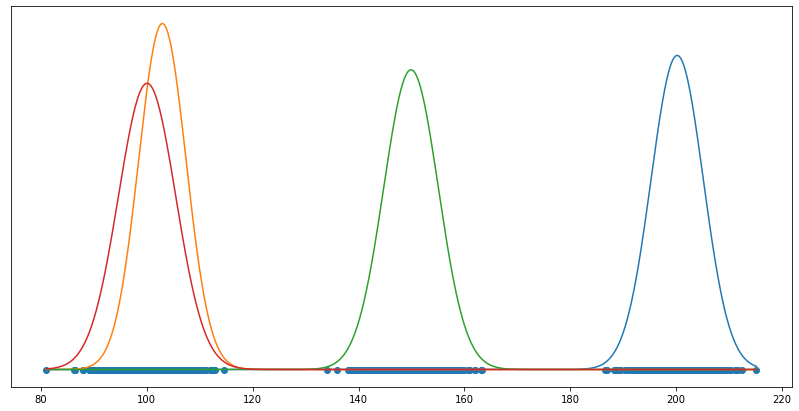

[153.67860424 200.17063127 104.58498005 145.3962873   95.89449166]
5 8344.188234902114


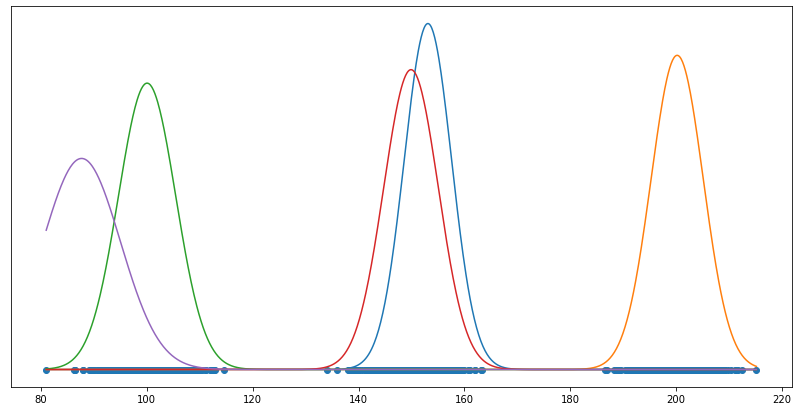

[         nan 148.18261233          nan          nan          nan
          nan]
6 nan


<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


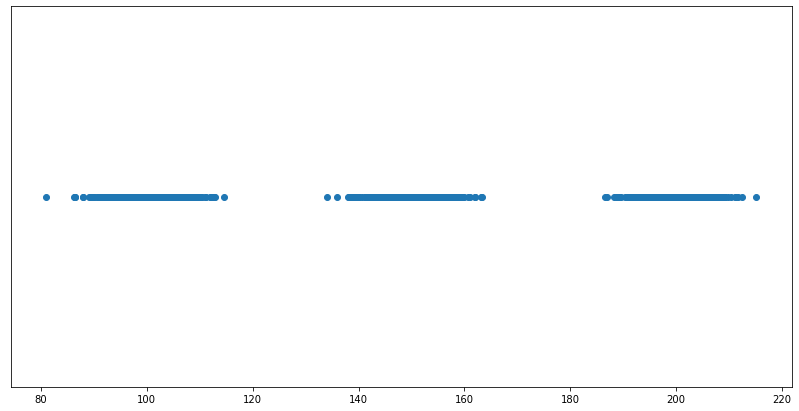

[         nan 148.18261233          nan          nan          nan
          nan          nan]
7 nan


<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


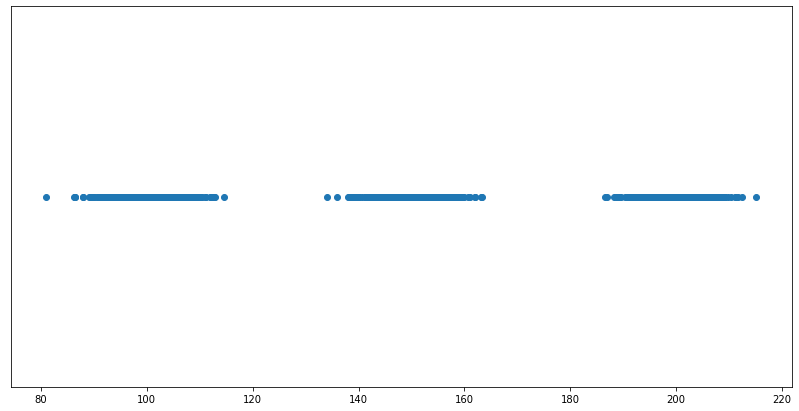

[200.17063127 106.29500432 146.67114412  93.42461854 141.35639567
 157.17022929 151.42125322  99.90405   ]
8 8361.812171533737


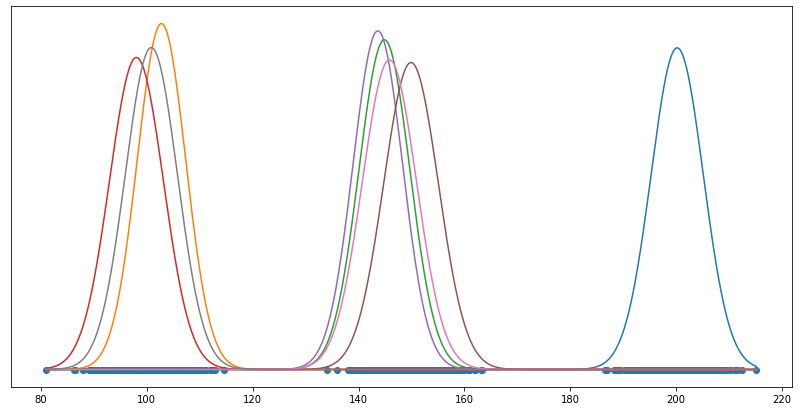

[         nan 148.18261233          nan          nan          nan
          nan          nan          nan          nan]
9 nan


<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


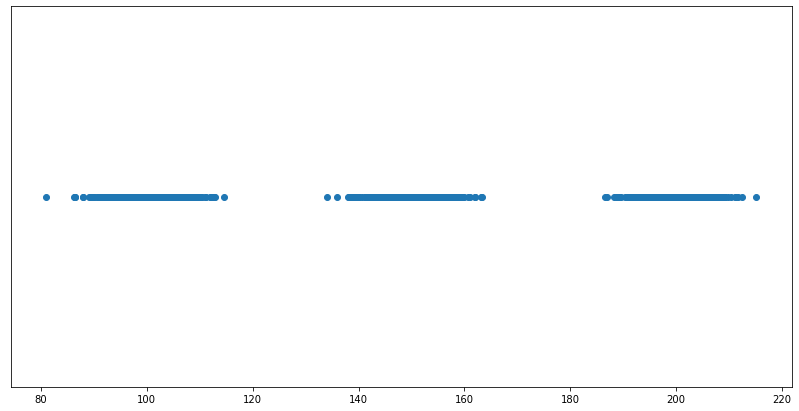

[148.18261233          nan          nan          nan          nan
          nan          nan          nan          nan          nan]
10 nan


<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


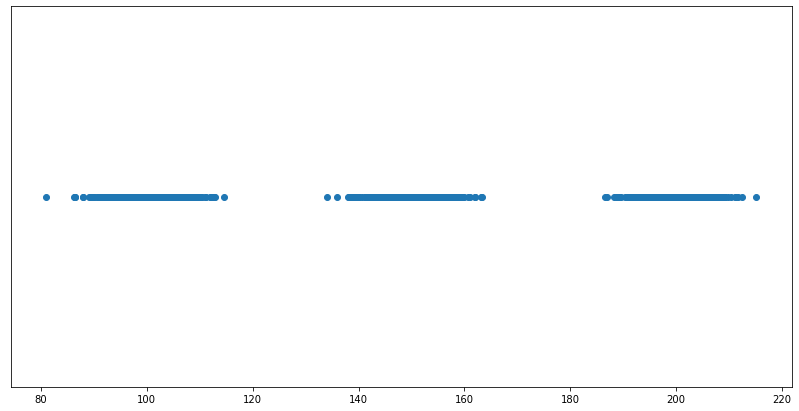

<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[148.18261233          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan]
11 nan


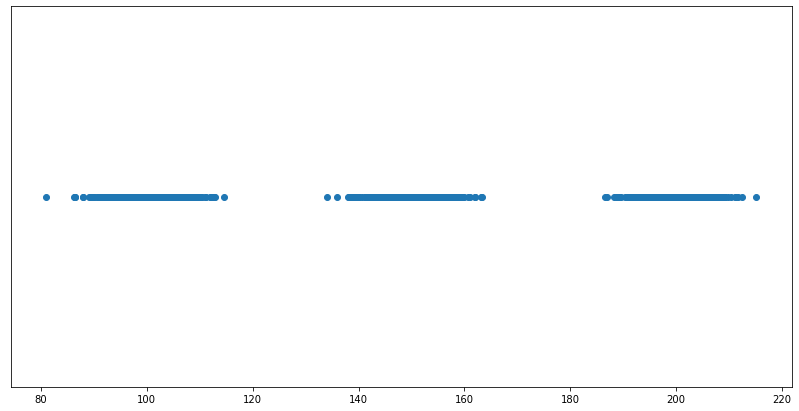

<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[         nan 148.18261233          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan]
12 nan


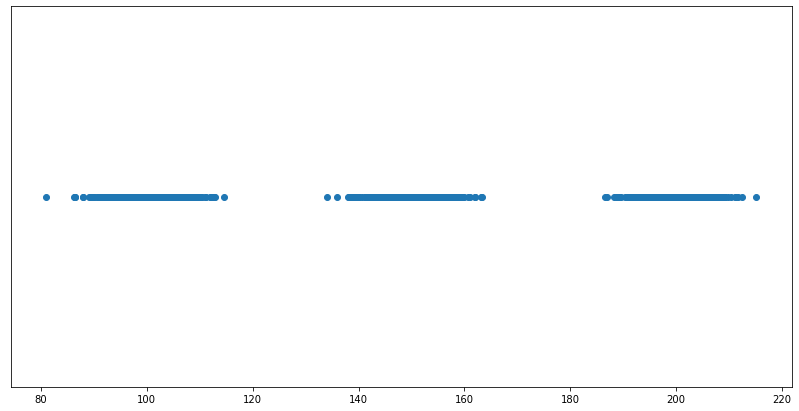

<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[148.18261233          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan]
13 nan


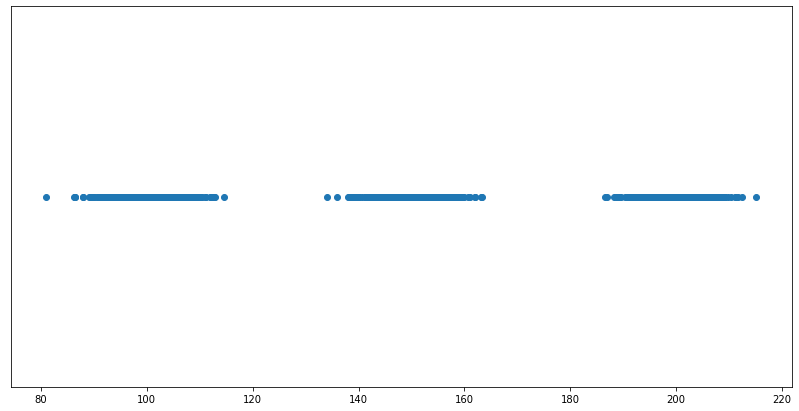

[ 90.65675848 208.24902883 145.3962873  205.28933657  96.20275568
 202.18684004 211.33809468 106.78638362 215.13285134 190.73041695
 153.67860424 198.58651108 100.96961843 195.02109703]
14 8398.188216262733


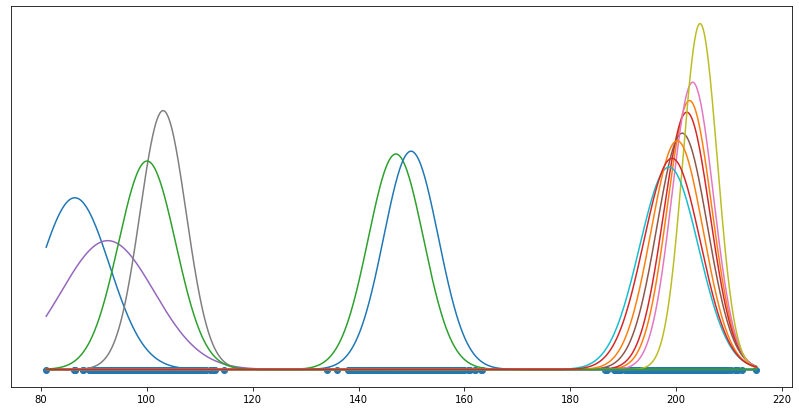

<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[148.18261233          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan]
15 nan


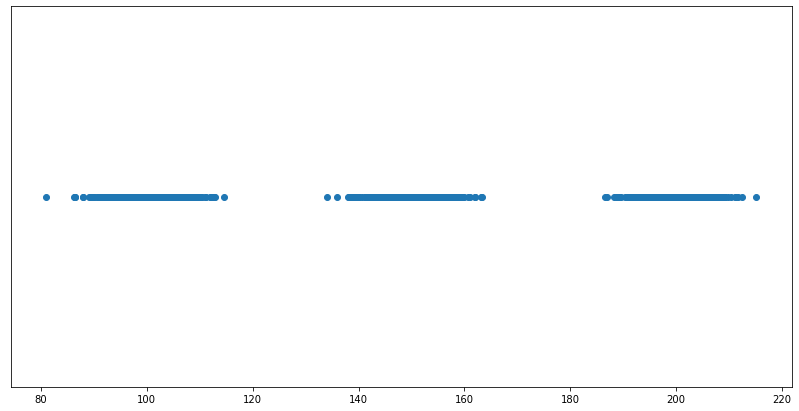

best model:


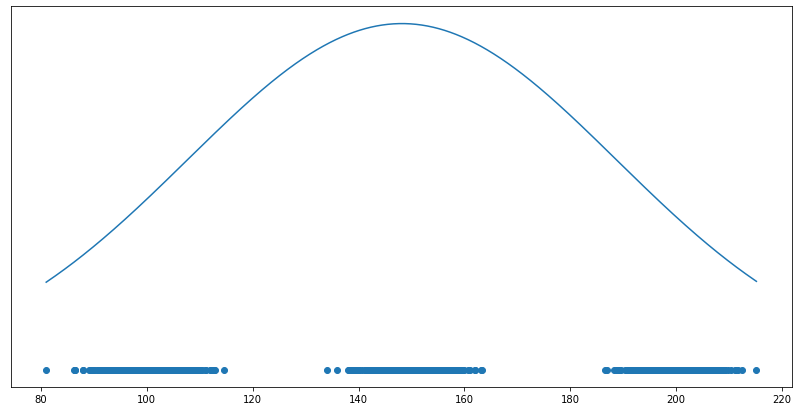

In [13]:
sel_plt(sample_x)

[3.75866667]
1 599.0248904869825


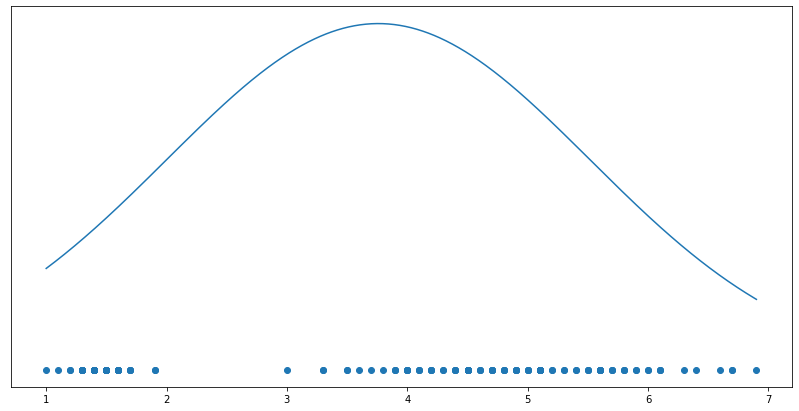

This is the new best model according to aic (above)!
[4.92525253 1.49411765]
2 411.07085197276035


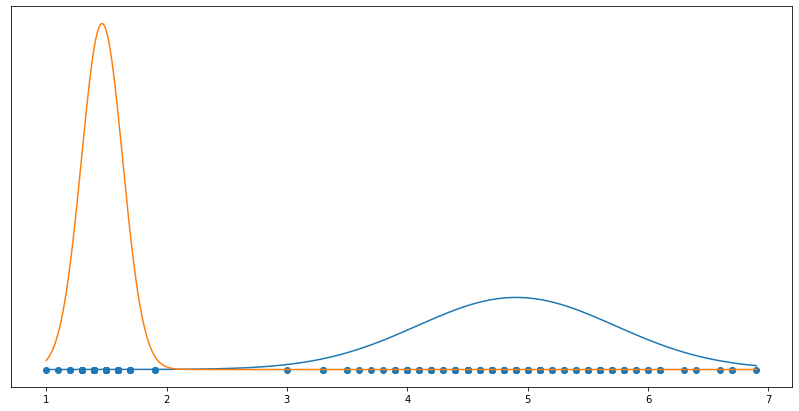

[5.62826087 1.464      4.29074074]
3 417.070849967379


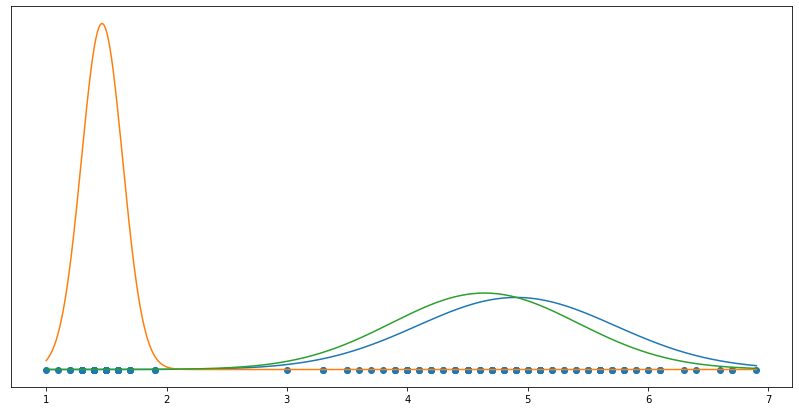

[4.8744186  1.464      3.95517241 5.93928571]
4 423.07084797077795


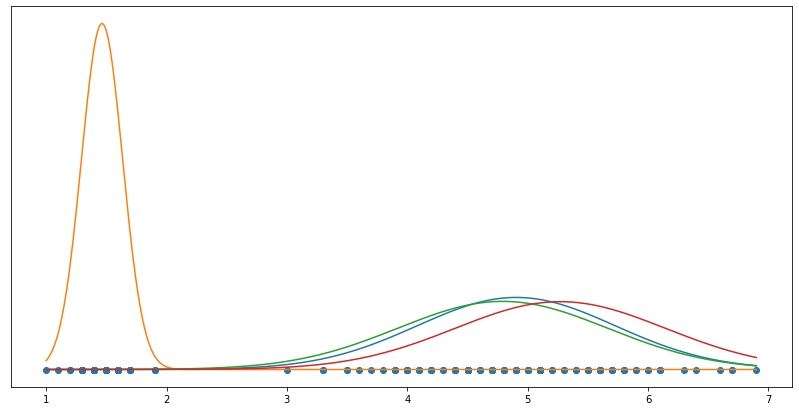

[1.464      3.884      6.35454545 5.57391304 4.76585366]
5 429.07084591663147


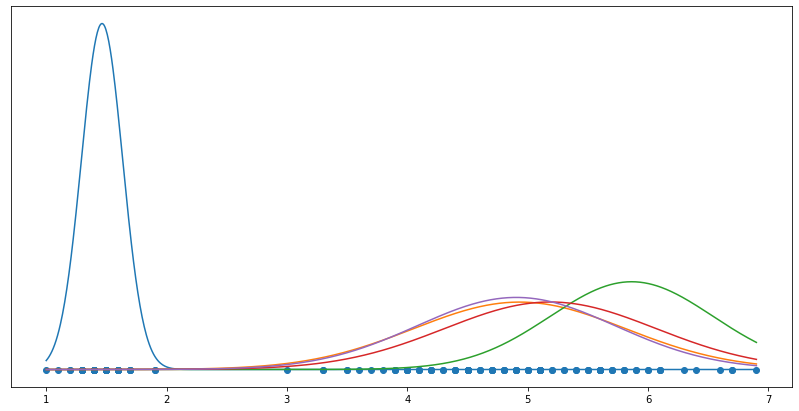

[4.90967742 5.60952381 6.35454545 1.44583333 4.10277778 2.26666667]
6 435.0708442565496


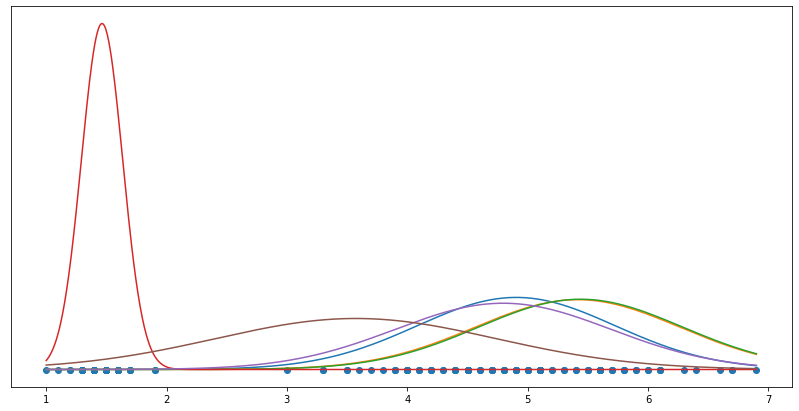

[1.464      4.14285714 5.69615385 3.2        4.82564103 3.62
 6.6       ]
7 441.0708416984085


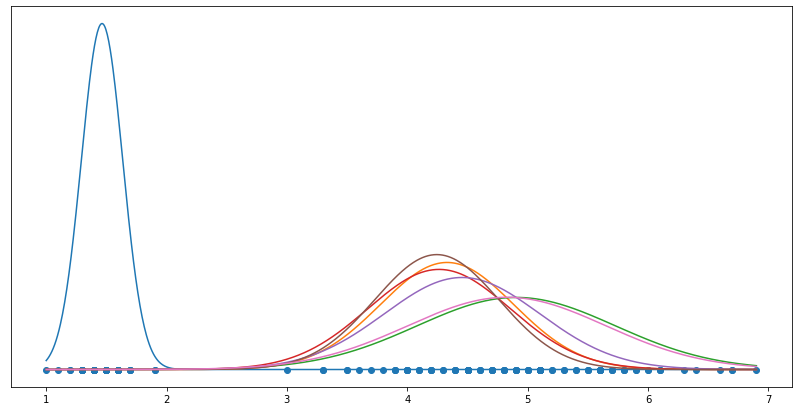

[1.9        4.96666667 6.6        3.4625     5.72916667 1.56
 4.275      1.32173913]
8 447.0708402899224


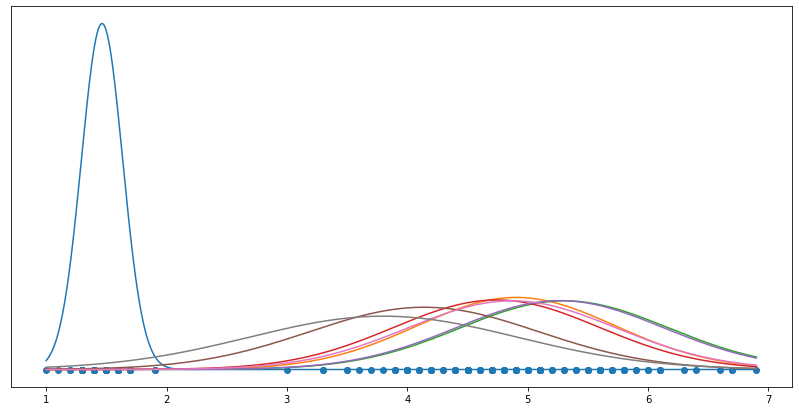

[3.41428571 4.47058824 4.0375     6.43333333 1.23636364 5.18571429
 5.70526316 4.84444444 1.52820513]
9 453.0708377137048


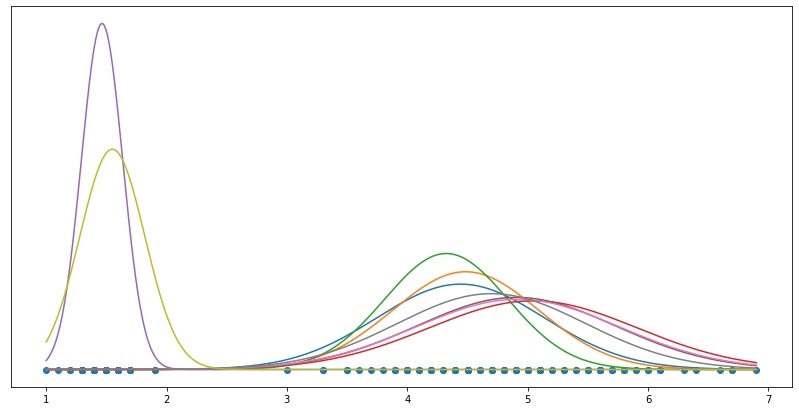

[       nan 3.75866667        nan        nan        nan        nan
        nan        nan        nan        nan]
10 nan


<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


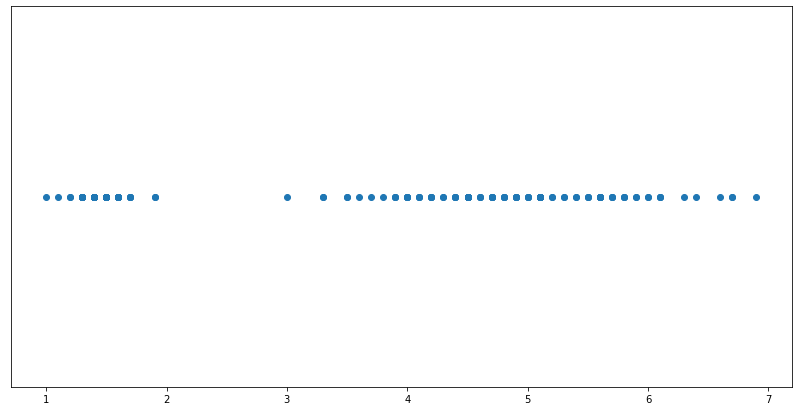

[       nan 3.75866667        nan        nan        nan        nan
        nan        nan        nan        nan        nan]
11 nan


<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


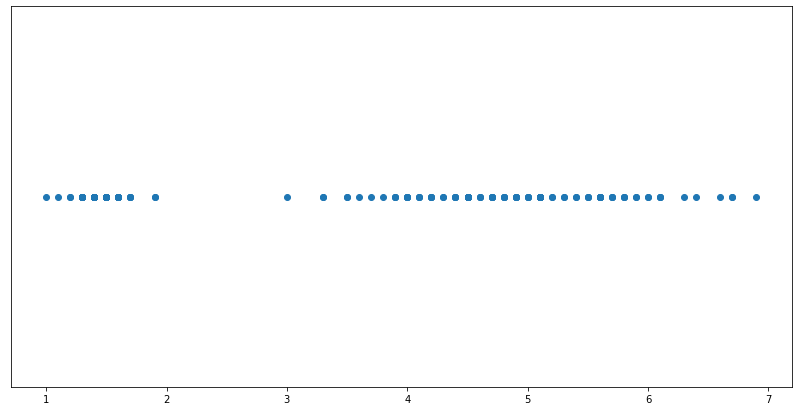

<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[3.75866667        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
12 nan


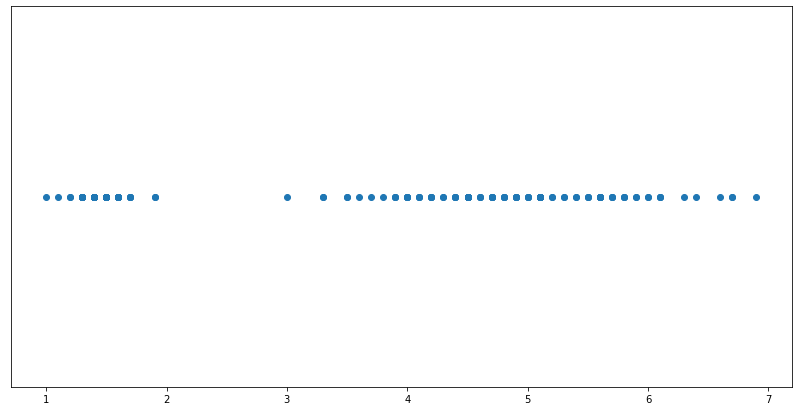

<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[       nan 3.75866667        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan]
13 nan


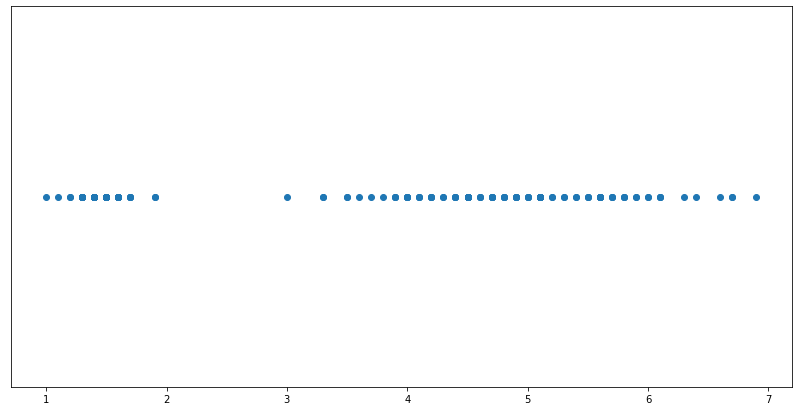

<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[       nan 3.75866667        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
14 nan


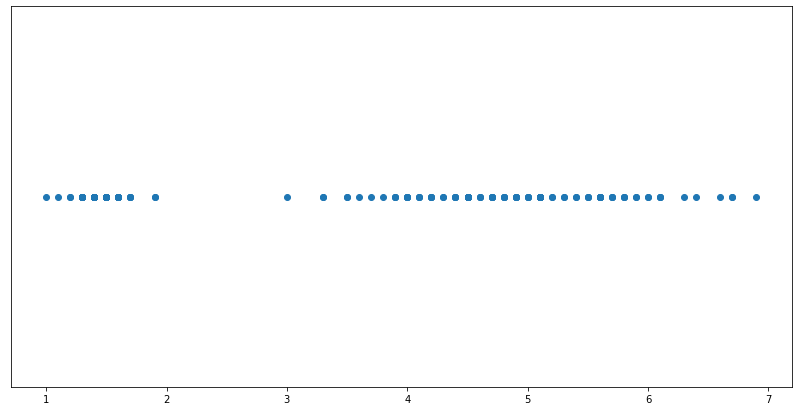

<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[       nan 3.75866667        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]
15 nan


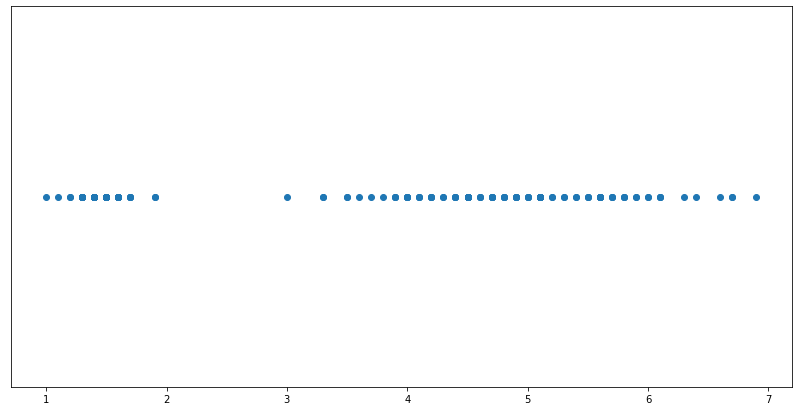

best model:


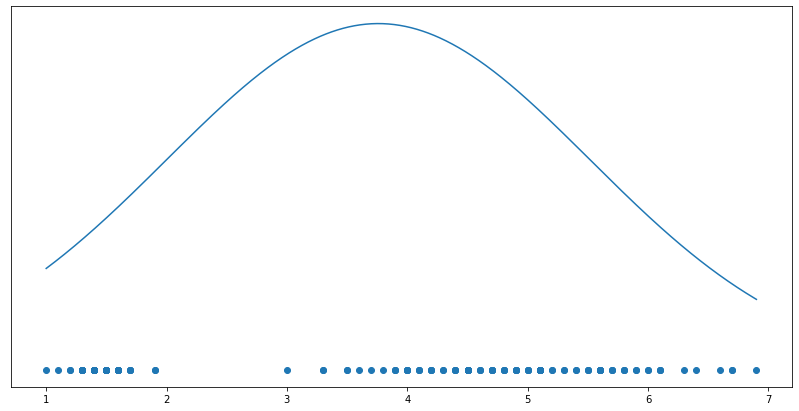

In [14]:
sel_plt(iris_x)

[100.45364238]
1 2790.4060160663075


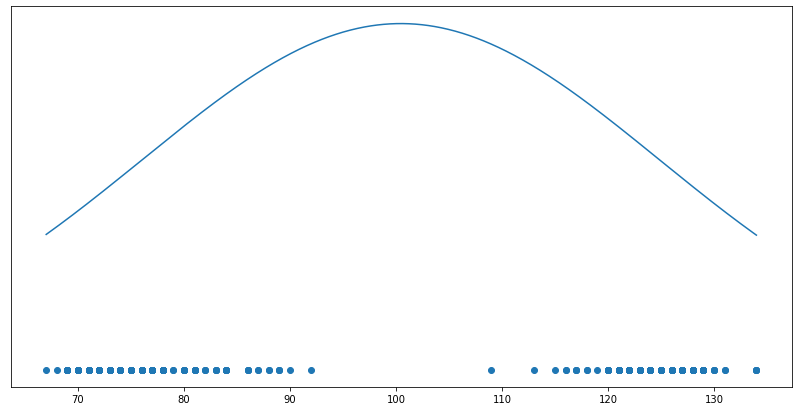

This is the new best model according to aic (above)!
[ 76.50993377 124.39735099]
2 2203.9131940815037


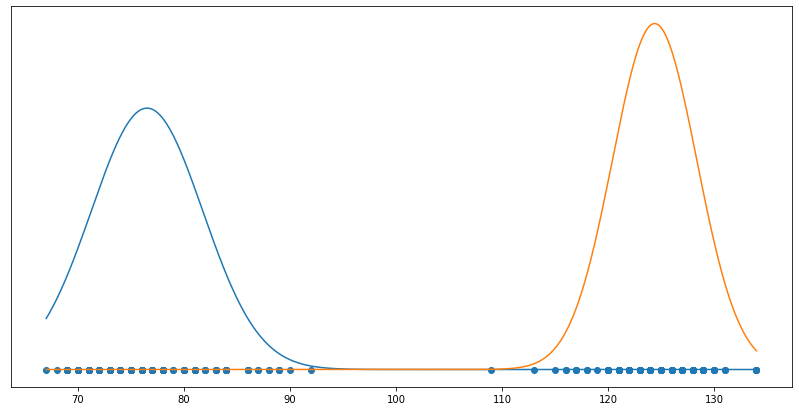

[128.40740741 122.16494845  76.50993377]
3 2204.302027635155


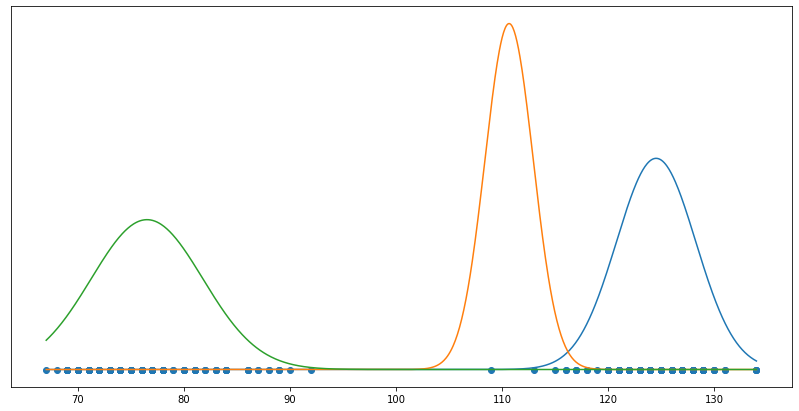

[122.96511628 128.40740741  76.50993377 115.90909091]
4 2210.0100244960004


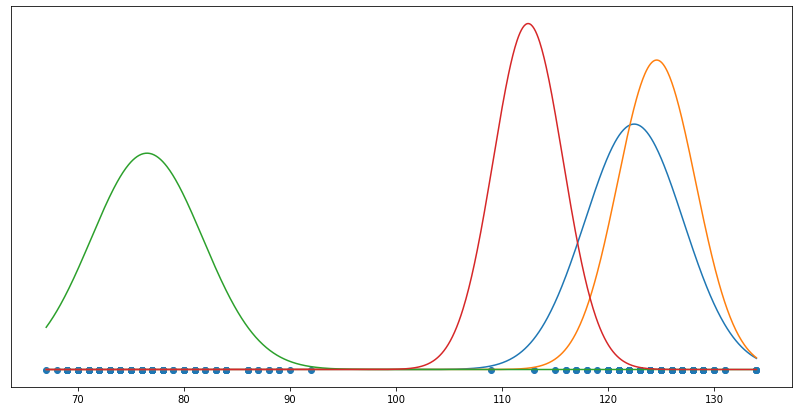

[         nan 100.45364238          nan          nan          nan]
5 nan


<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


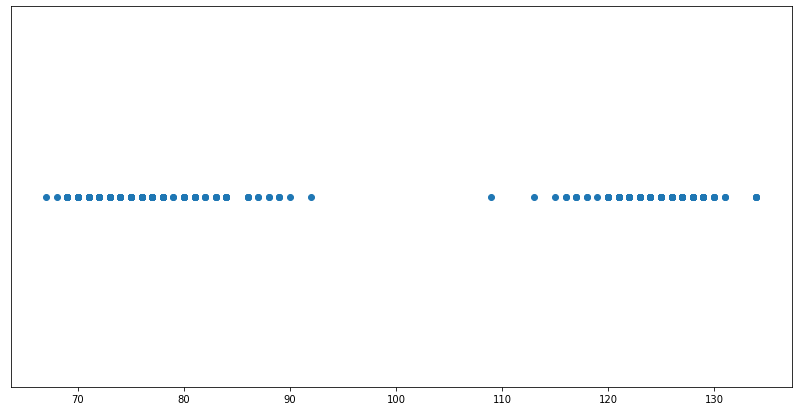

[100.45364238          nan          nan          nan          nan
          nan]
6 nan


<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


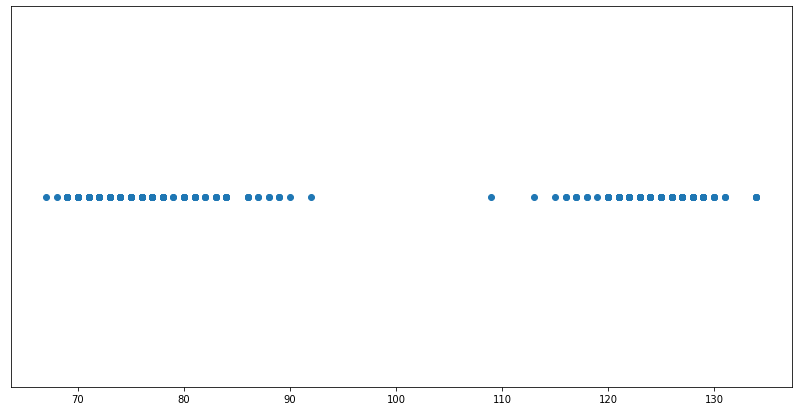

<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[         nan 100.45364238          nan          nan          nan
          nan          nan]
7 nan


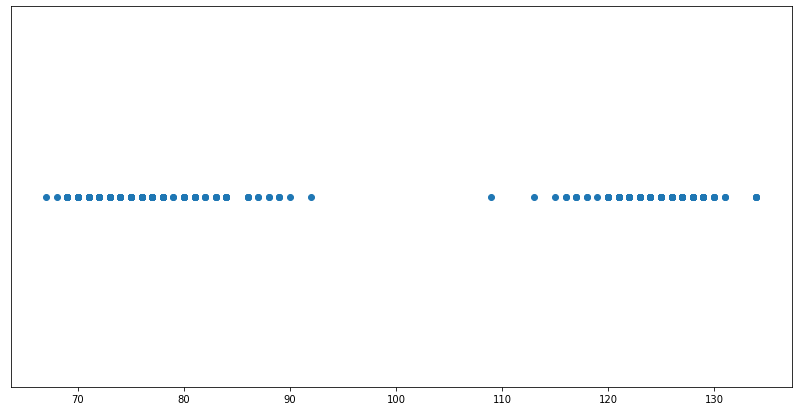

<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[100.45364238          nan          nan          nan          nan
          nan          nan          nan]
8 nan


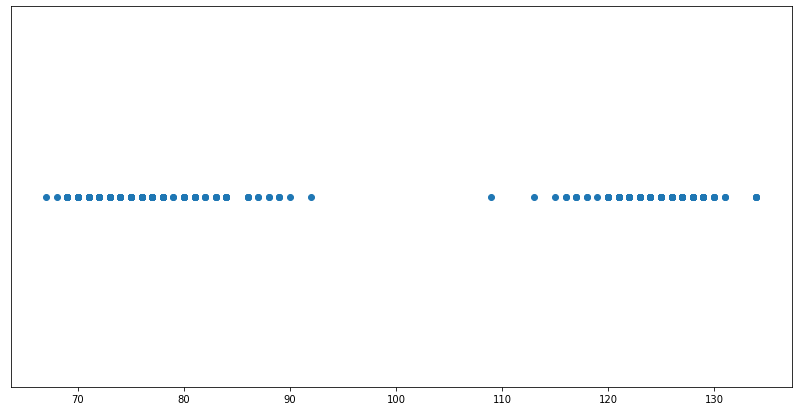

[114.         125.32142857  80.77777778 117.25       129.4
 121.67346939  87.92307692  73.54901961 109.        ]
9 2218.581637545869


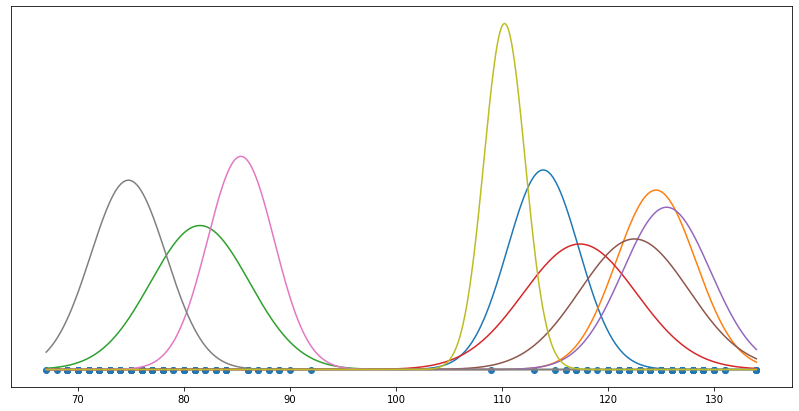

[         nan 100.45364238          nan          nan          nan
          nan          nan          nan          nan          nan]
10 nan


<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


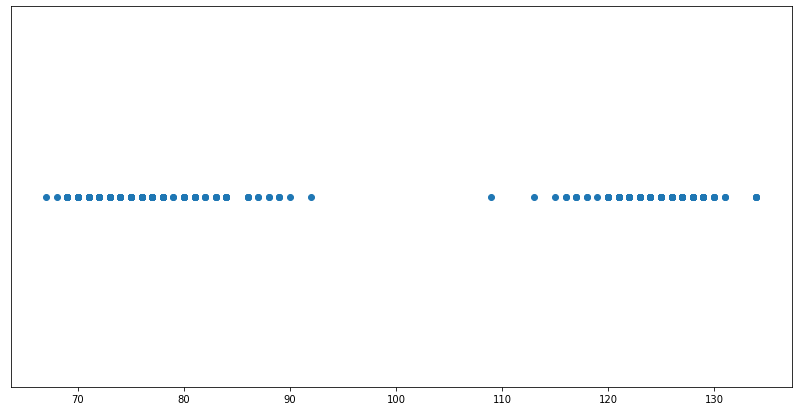

[         nan 100.45364238          nan          nan          nan
          nan          nan          nan          nan          nan
          nan]
11 nan


<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


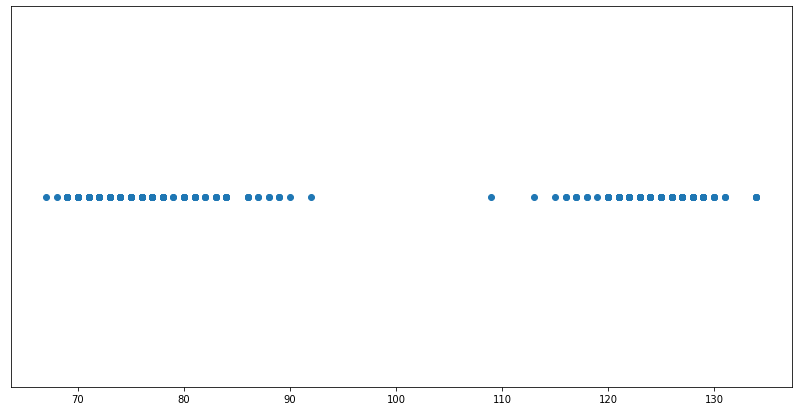

<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[         nan 100.45364238          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan]
12 nan


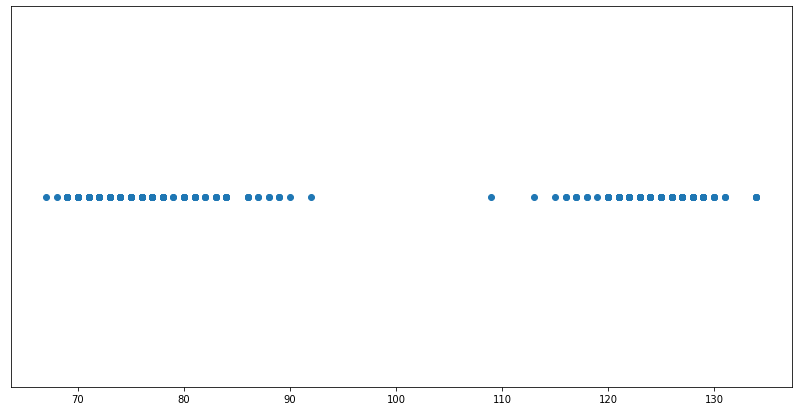

<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[         nan 100.45364238          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan]
13 nan


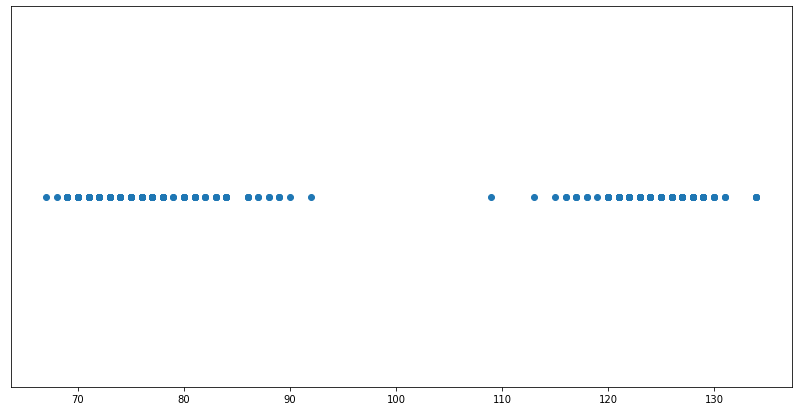

<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[100.45364238          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan]
14 nan


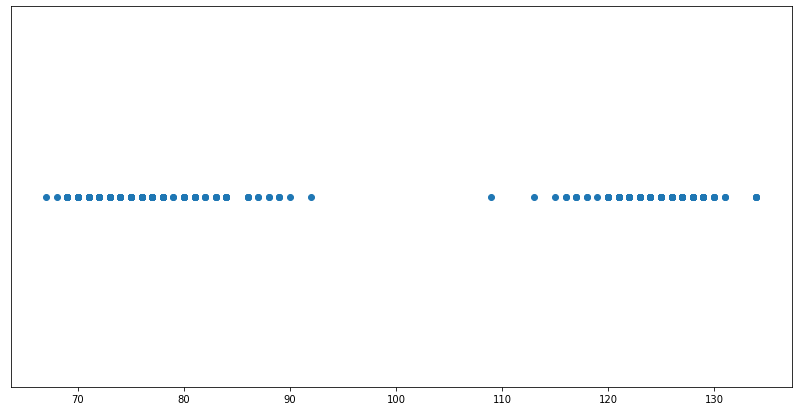

<ipython-input-4-2454d8ee7509>:26: RuntimeWarning: Mean of empty slice.
  mu[j] = data[cluster_indices == j].mean()
/home/me/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[         nan 100.45364238          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan]
15 nan


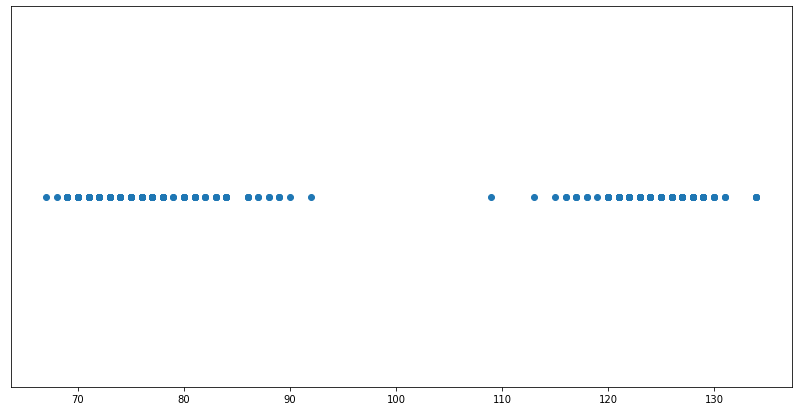

best model:


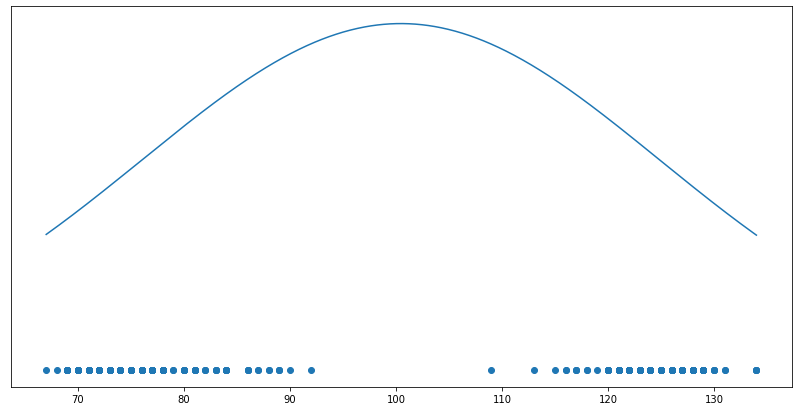

In [15]:
sel_plt(bdp_x)